<a href="https://colab.research.google.com/github/stanchanpsu/total-comp/blob/main/prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Installs
# Installs
%%capture
!pip install yfinance

In [ ]:
# @title Imports
%%capture
import yfinance as yf
from dataclasses import dataclass
from datetime import datetime
from dateutil.relativedelta import relativedelta
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [ ]:
# @title Disable logging from yfinance
import logging
logger = logging.getLogger('yfinance')
logger.disabled = True
logger.propagate = False

In [ ]:
# @title Grant dataclass
@dataclass
class Grant:
    name: str
    symbol: str
    total_shares: float
    grant_equity: float
    grant_price: float
    vest_months: int
    first_vest_date: datetime
    vested_shares: int = 0
    unvested_shares: int = 0
    current_price: float = 0.0
    vested_equity: float = 0.0
    unvested_equity: float = 0.0

    def __post_init__(self):
        self.calculate_values(datetime.now())
        self.calculate_vesting_schedule()

    def calculate_vested_shares(self, as_of_date):
        if as_of_date < self.first_vest_date:
            return 0.0
        elif as_of_date > self.last_vest_date:
            return self.total_shares
        else:
            difference = relativedelta(as_of_date, self.first_vest_date)
            # The first_vest_date is a vest, so add 1 to the months vested.
            months_vested = difference.years * 12 + difference.months + 1
            return self.total_shares * min(months_vested / self.vest_months, 1.0)

    def calculate_values(self, as_of_date):
        self.last_vest_date = self.first_vest_date + relativedelta(months=+self.vest_months)
        self.vested_shares = math.floor(self.calculate_vested_shares(as_of_date))
        self.unvested_shares = self.total_shares - self.vested_shares
        self.current_price = self.get_current_stock_price()
        self.unvested_equity = self.unvested_shares * self.current_price

    def get_current_stock_price(self):
        ticker = yf.Ticker(self.symbol)
        price = ticker.info["currentPrice"]
        return price

    def get_stock_price(self, date):
        ticker = yf.Ticker(self.symbol)
        price = self.current_price
        # Try up to 3 times for weekends and holidays
        for i in range(1, 4):
            try:
                price = ticker.history(start=date, end=date+relativedelta(days= +i))["Close"][0]
                break
            except Exception as e:
                pass
        return price

    def calculate_vesting_schedule(self):
        vesting_schedule = []
        for i in range(self.vest_months):
            date = self.first_vest_date + relativedelta(months=+i)
            # Vest price
            price = self.current_price
            vested = date < datetime.now()
            if vested:
                price = self.get_stock_price(date)
            shares = self.total_shares / self.vest_months
            # Rounding based on which vest date
            shares = math.floor(shares) if date == self.first_vest_date else math.ceil(shares)
            equity = round(price * shares, 2)
            row = [date, vested, price, shares, equity]
            vesting_schedule.append(row)

            # Add the vested_equity
            if vested:
                self.vested_equity += equity
        self.vesting_schedule = pd.DataFrame(columns = ["date", "vested", "price", "shares", "equity"], data = vesting_schedule)



In [ ]:
# @title AnnualCompensation dataclass
@dataclass
class AnnualCompensation:
    year: int = 2024
    base: float = 0.0
    bonus: float = 0.0
    equity: float = 0.0

    @property
    def total_compensation(self):
        return round(self.base + self.bonus + self.equity, 2)

    def to_list(self):
        return [self.year, self.base, self.bonus, self.equity, self.total_compensation]

In [ ]:
# @title Grants
# @markdown Fill in the information for up to 2 grants.
# @markdown # Grant 1
name = "New hire grant" # @param {type:"string"}
symbol = "SNAP" # @param {type:"string"}
total_shares = 20000 # @param {type:"integer"}
grant_price = 10 # @param {type:"number"}
grant_equity = 50000 # @param {type:"number"}
first_vest_date = "2023-12-15" # @param {type:"date"}
first_vest_date_datetime = datetime.strptime(first_vest_date, '%Y-%m-%d')
vest_months = 36 # @param {type:"integer"}

g1 = Grant(name=name, symbol=symbol, total_shares=total_shares, grant_equity=grant_equity, grant_price=grant_price, vest_months=vest_months, first_vest_date=first_vest_date_datetime)


# @markdown # Grant 2
name = "Refresher 1" # @param {type:"string"}
symbol = "SNAP" # @param {type:"string"}
total_shares = 20000 # @param {type:"integer"}
grant_price = 10 # @param {type:"number"}
grant_equity = 50000 # @param {type:"number"}
first_vest_date = "2023-12-15" # @param {type:"date"}
first_vest_date_datetime = datetime.strptime(first_vest_date, '%Y-%m-%d')
vest_months = 36 # @param {type:"integer"}

g2 = Grant(name=name, symbol=symbol, total_shares=total_shares, grant_equity=grant_equity, grant_price=grant_price, vest_months=vest_months, first_vest_date=first_vest_date_datetime)


# Grants
grants = [g1, g2]

g1.vesting_schedule


,date,vested,price,shares,equity
0,2023-12-15,True,16.92,555,9390.60
1,2024-01-15,True,15.54,556,8640.24
2,2024-02-15,True,11.60,556,6449.60
3,2024-03-15,True,11.19,556,6221.64
4,2024-04-15,True,10.34,556,5749.04
5,2024-05-15,False,14.55,556,8089.80
6,2024-06-15,False,14.55,556,8089.80
7,2024-07-15,False,14.55,556,8089.80
8,2024-08-15,False,14.55,556,8089.80
9,2024-09-15,False,14.55,556,8089.80


In [ ]:
# @title Years
annual_compensations = [
    AnnualCompensation(year = 2024, base = 195000),
    AnnualCompensation(year = 2025, base = 195000),
    AnnualCompensation(year = 2026, base = 195000),
    AnnualCompensation(year = 2027, base = 195000)
]

In [ ]:
# @title Aggregate into chart data
chart_data = []

for ac in annual_compensations:
    ac.equity = 0
    for grant in grants:
        for index, vest in grant.vesting_schedule.iterrows():
            if vest["date"].year == ac.year:
                ac.equity += vest["equity"]
    ac.equity = round(ac.equity, 2)
    chart_data.append(ac.to_list())

dataframe = pd.DataFrame(columns = ["year", "base", "bonus", "equity", "total"],
                         data = chart_data)

dataframe

,year,base,bonus,equity,total
0,2024,195000,0.0,183557.84,378557.84
1,2025,195000,0.0,194155.20,389155.20
2,2026,195000,0.0,177975.60,372975.60
3,2027,195000,0.0,0.00,195000.00


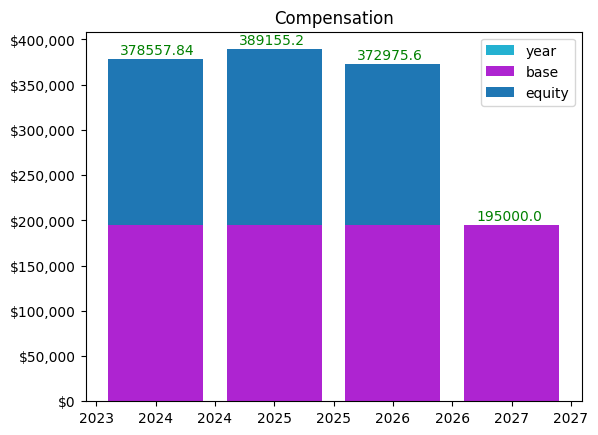

In [ ]:
# @title Plot chart
def chart_annual_compensation():
    def dollar_format(x, pos):
        return "${:0,.0f}".format(x)

    fig, ax = plt.subplots()
    ax.get_yaxis().set_major_formatter(FuncFormatter(dollar_format))
    ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, pos: int(x)))
    ax.bar(dataframe.year, dataframe['year'], label = 'year', color = '#24b1d1')
    ax.bar(dataframe.year, dataframe['base'], label='base', color = '#ae24d1')
    ax.bar(dataframe.year, dataframe['equity'], label='equity', bottom=dataframe['base'])
    for i, total in enumerate(dataframe['total']):
        ax.text(x = dataframe['year'][i] - 0.3, y = total + 5000, s = total, color = 'green')
    ax.set_title('Compensation')
    _ = ax.legend()

chart_annual_compensation()